# Forecasting taxi orders

The Clear Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour. Build a model to make this prediction.

The *RMSE* metric value on the test sample should be no more than 48.

You need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on a test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column (from the English *number of orders*, “number of orders”).

## Preparation

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

## Analysis

1.Data loading and resampling

In [2]:
data = pd.read_csv('datasets/taxi.csv', parse_dates=['datetime'],
                   index_col='datetime')
data.info()
data.head(3)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [3]:
#we will resample for 1 hour

if not data.index.is_monotonic:
    data = data.sort_index()
    
data = data.resample('1H').sum()


data.index.min(), data.index.max()




/var/folders/jm/05ch517x2v976nq1w0l5znn40000gn/T/ipykernel_17201/3477169840.py:3: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not data.index.is_monotonic:


(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

2. Study of temporal patterns

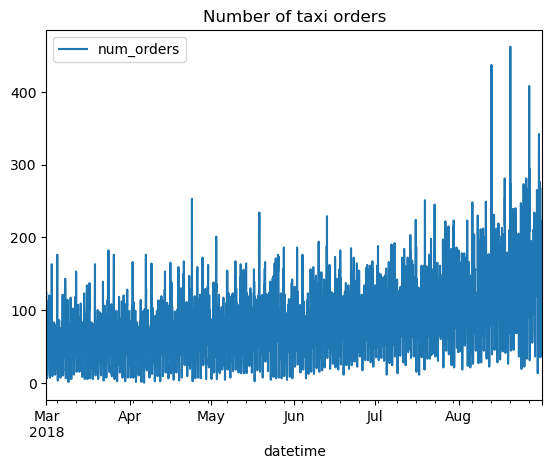

In [4]:


data.plot(title='Number of taxi orders');



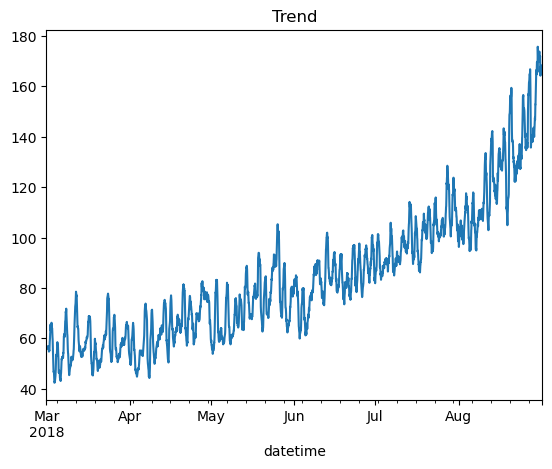

In [5]:


decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(title='Trend');




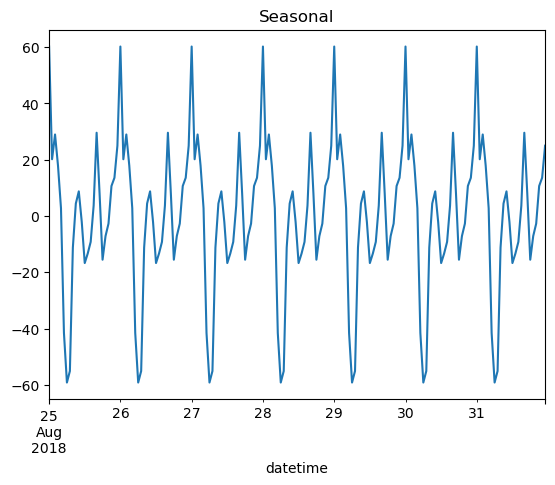

In [6]:
decomposed_data.seasonal.tail(24*7).plot(title='Seasonal');


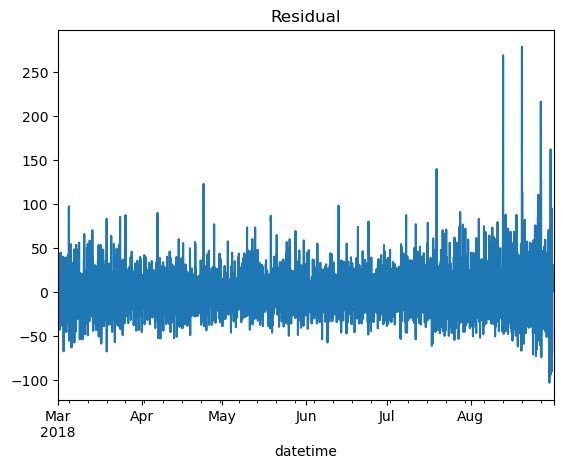

In [7]:
decomposed_data.resid.plot(title='Residual');

Data shows daily seasonality and upward trend

## Training

In [8]:
# let's create a function to transform data with different time lags and
# moving average window
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


We will select parameters for several models using different values of the time lag and moving average window

*1. LightGBM Regressor*

In [9]:
model_gbm=LGBMRegressor(random_state=12345)
cv = TimeSeriesSplit(n_splits=5)
params = {
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
}
# choosing of hyperparameters with RandomizedSearchCV
gs_gbm = RandomizedSearchCV(
    model_gbm,
    cv=cv,
    param_distributions=params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=12345,
    verbose=True
)
best_score=48
best_max_lag=0
best_rolling_mean_size=0
best_params=0
for max_lag in [24,168]:
    for rolling_mean_size in [24,168]:
        make_features(data, max_lag, rolling_mean_size)
        data=data.dropna()
        features=data.drop('num_orders',axis=1)
        target=data['num_orders']
        features_train,features_test,target_train,target_test=train_test_split(features,target, shuffle=False, test_size=0.1)
        gs_gbm.fit(features_train, target_train)
        gs_gbm_best_score = gs_gbm.best_score_ * -1
        gs_gbm_best_params = gs_gbm.best_params_
        if gs_gbm_best_score<best_score:
            best_score=gs_gbm_best_score
            best_max_lag=max_lag
            best_rolling_mean_size=rolling_mean_size
            best_params=gs_gbm_best_params
print(best_score)
print(best_max_lag)
print(best_rolling_mean_size)
print(best_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/artembonchuk/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/var/folders/jm/05ch517x2v976nq1w0l5znn40000gn/T/ipykernel_17201/790839950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data.index.day
/var/folders/jm/05ch517x2v976nq1w0l5znn40000gn/T/ipykernel_17201/790839950.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/var/folders/jm/05ch517x2v976nq1w0l5znn40000gn/T/ipykernel_17201/790839950.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/var/folders/jm/05ch517x2v976nq1w0l5znn40000gn/T/ipykernel_17201/790839950.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/var/folders/jm/05ch517x2v976nq1w0l5znn40000gn/T/ipykernel_17201/790839950.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/artembonchuk/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
23.21341753249196
168
24
{'num_leaves': 21, 'n_estimators': 60}


*2. RandomForest Regressor*

In [10]:
model_rf=RandomForestRegressor(random_state=12345)
cv = TimeSeriesSplit(n_splits=5)

# using RandomizedSearchCV
param_grid_rf = {
    'n_estimators': range(50, 251, 50),
    'max_depth': range(2, 15),
}
gs_rf = RandomizedSearchCV(
    model_rf,
    cv=cv,
    param_distributions=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=12345,
    verbose=True
)
best_score=48
best_max_lag=0
best_rolling_mean_size=0
best_params=0
for max_lag in [24,168]:
    for rolling_mean_size in [24,168]:
        make_features(data, max_lag, rolling_mean_size)
        data=data.dropna()
        features=data.drop('num_orders',axis=1)
        target=data['num_orders']
        features_train,features_test,target_train,target_test=train_test_split(features,target, shuffle=False, test_size=0.1)
        gs_rf.fit(features_train, target_train)
        gs_rf_best_score = gs_rf.best_score_ * -1
        gs_rf_best_params = gs_rf.best_params_
        if gs_rf_best_score<best_score:
            best_score=gs_rf_best_score
            best_max_lag=max_lag
            best_rolling_mean_size=rolling_mean_size
            best_params=gs_rf_best_params
print(best_score)
print(best_max_lag)
print(best_rolling_mean_size)
print(best_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
23.288386817701586
24
24
{'n_estimators': 150, 'max_depth': 13}


**Conclusion**

Both models demonstrate almost the same reliability of predictions on the training set. In both cases, the optimal value of the maximum time lag is one day, and the size of the moving average time window is 168 hours (one week).

## Testing

Let's check the effectiveness of predictions with selected parameters on a test sample using the LightGBM model

In [11]:
make_features(data, 168, 24)
data=data.dropna()
features=data.drop('num_orders',axis=1)
target=data['num_orders']
features_train,features_test,target_train,target_test=train_test_split(features,target, shuffle=False, test_size=0.1)
model_gbm=LGBMRegressor(num_leaves=21, n_estimators=60, learning_rate=0.1,random_state=12345)
model_gbm.fit(features_train, target_train)
prediction=model_gbm.predict(features_test)
score=(mean_squared_error(target_test, prediction))**0.5
print('RMSE on test dataset:', score)

RMSE on test dataset: 38.50137364267106


**Conclusion**

Both using RandomForest and LightGBM, it was possible to achieve reliable prediction with RMSE of about 23 on the test sample, the optimal value of the maximum time lag is one day, and the size of the moving average time window is 168 hours (one week), which is understandable, since in The data has a weekly seasonality. For prediction on the test set, the LightGBM model was chosen because it learns faster. On the test set, the model with hyperparameters selected on the training set demonstrated the reliability of the prediction with RMSE 37.94, which is less than the required one (48) and allows this model to be used to predict the number of orders.